# Testing Best Batch size on Fashion MNIST Dataset
The goal if this experiment is to determine how altering the batch size of training data affects convergence time, and affects the overall efficiency and accuracy of the model.
We will be using the fashion mnist dataset.

## Getting The Data

In [26]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from datetime import datetime

(full_train_data, test_data), ds_info = tfds.load(name="fashion_mnist",
                                        split=["train", "test"],
                                        with_info=True,
                                        as_supervised=True,
                                        shuffle_files=True)

In [27]:
len_full_train_dataset = tf.data.experimental.cardinality(full_train_data).numpy()
full_train_data = full_train_data.shuffle(buffer_size=len_full_train_dataset)
train_size = int(0.8*len_full_train_dataset)

train_data = full_train_data.take(train_size)
val_data = full_train_data.skip(train_size)


In [28]:
tf.data.experimental.cardinality(train_data).numpy(), tf.data.experimental.cardinality(val_data).numpy()

(48000, 12000)

## Confirming Data

In [29]:
train_sample = train_data.take(1)
class_names = ds_info.features["label"].names

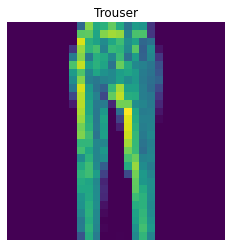

In [30]:
for image, label in train_sample:
  plt.imshow(image)
  plt.title(class_names[label])
  plt.axis(False)

In [31]:
for image, label in train_sample:
  print(image.shape)

(28, 28, 1)


## Setting up preprocessing and checkpoints

In [32]:
def preprocess_img(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.
  return (tf.cast(image, tf.float32), label)

## Training and collecting data

In [34]:
tf.random.set_seed(42)
results = {}

for batch_size in range(4, 257, 4):
  print(f"Working on batch_size: {batch_size}")
  train_data_preprocessed = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
  train_data_ready = train_data_preprocessed.shuffle(buffer_size=1024).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
  val_data_ready = val_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
  test_data_ready = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

  checkpoint_base = tf.keras.callbacks.ModelCheckpoint(f"models/checkpoints/model_batch_size_{batch_size}.h5",
                                                        save_best_only=True,
                                                        monitor="val_loss",
                                                        verbose=0)

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3)
  
  start_time = datetime.now()

  input_shape = (28, 28, 1)
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10,3, activation="relu", input_shape=input_shape),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2,padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation="softmax")                                                   
  ])


  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

  history = model.fit(train_data_ready,
                      epochs=100,
                      steps_per_epoch=len(train_data_ready),
                      validation_data=val_data_ready,
                      validation_steps=len(val_data_ready),
                      callbacks=[early_stopping, checkpoint_base])

  loaded_model = tf.keras.models.load_model(f"models/checkpoints/model_batch_size_{batch_size}.h5")

  time_taken = (datetime.now() - start_time).total_seconds()
  loss, accuracy = loaded_model.evaluate(test_data_ready)
  results[batch_size] = {'loss': loss,
                         'accuracy': accuracy,
                         'no_of_epochs': len(history.epoch),
                         'total_seconds': time_taken}


Working on batch_size: 4
Epoch 1/100
12000/12000 [==============================] - 59s 5ms/step - loss: 0.4300 - accuracy: 0.8473 - val_loss: 0.3205 - val_accuracy: 0.8859
Epoch 2/100
12000/12000 [==============================] - 60s 5ms/step - loss: 0.3032 - accuracy: 0.8914 - val_loss: 0.3023 - val_accuracy: 0.8873
Epoch 3/100
12000/12000 [==============================] - 60s 5ms/step - loss: 0.2687 - accuracy: 0.9048 - val_loss: 0.2201 - val_accuracy: 0.9207
Epoch 4/100
12000/12000 [==============================] - 60s 5ms/step - loss: 0.2505 - accuracy: 0.9099 - val_loss: 0.2283 - val_accuracy: 0.9187
Epoch 5/100
12000/12000 [==============================] - 56s 5ms/step - loss: 0.2391 - accuracy: 0.9137 - val_loss: 0.2137 - val_accuracy: 0.9222
Epoch 6/100
12000/12000 [==============================] - 57s 5ms/step - loss: 0.2330 - accuracy: 0.9155 - val_loss: 0.2115 - val_accuracy: 0.9249
Epoch 7/100
12000/12000 [==============================] - 60s 5ms/step - loss: 0.2198 

## Graphing Results

In [35]:
import pandas as pd


In [36]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.head()

,loss,accuracy,no_of_epochs,total_seconds
4,0.285484,0.9024,13,924.656972
8,0.313867,0.9065,26,910.164912
12,0.290597,0.9018,21,610.470214
16,0.258234,0.9102,14,255.477700
20,0.280687,0.9050,17,279.598662


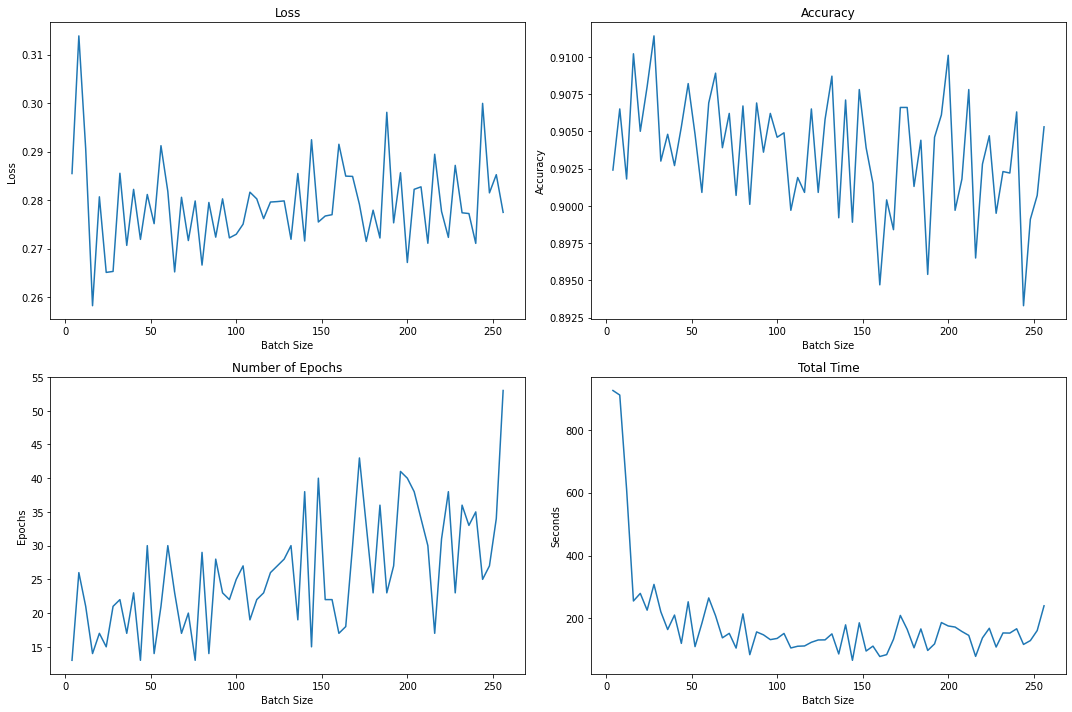

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

x = results_df.index

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(x, results_df['loss'])
ax1.set_title("Loss")
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Loss")
ax2.plot(x, results_df['accuracy'])
ax2.set_title("Accuracy")
ax2.set_xlabel("Batch Size")
ax2.set_ylabel("Accuracy")
ax3.plot(x, results_df['no_of_epochs'])
ax3.set_title("Number of Epochs")
ax3.set_xlabel("Batch Size")
ax3.set_ylabel("Epochs")
ax4.plot(x, results_df['total_seconds'])
ax4.set_title("Total Time")
ax4.set_xlabel("Batch Size")
ax4.set_ylabel("Seconds")

fig.tight_layout()